# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2023-10-27'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Get IQ data

In [4]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.1

IQ_data = simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
# IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

# Decode using predecoder

In [5]:
import pymatching
import stim
import cpp_soft_info
import numpy as np

model = simulator.stim_circ.detector_error_model(decompose_errors=False)
matching = pymatching.Matching.from_detector_error_model(model)

In [43]:
_DETAILED = True

result_predecoder = cpp_soft_info.decode_time_nn_predecode_grid(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED, threshold=0.25, _ntnn_edges = not _RESETS)


print(f"num_errors: {result_predecoder.decode_result.num_errors}")
print(f"mean num removed edges: {np.mean(result_predecoder.nb_rm_edges)}")
print(f"num removed edges: {np.sum(result_predecoder.nb_rm_edges)}")

num_errors: 122
mean num removed edges: 0.0642
num removed edges: 642


In [45]:
for threshold in np.linspace(0, 0.4, 20):
    result_predecoder_loop = cpp_soft_info.decode_time_nn_predecode_grid(model, IQ_data[:], ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                               simulator.processed_scaler_dict, _detailed=_DETAILED, threshold=threshold, _ntnn_edges = not _RESETS)
    print(f"threshold: {threshold}, num_errors: {result_predecoder_loop.decode_result.num_errors}, mean num removed edges: {np.mean(result_predecoder_loop.nb_rm_edges)}, num removed edges: {np.sum(result_predecoder_loop.nb_rm_edges)}")

threshold: 0.0, num_errors: 259, mean num removed edges: 1.6781, num removed edges: 16781
threshold: 0.021052631578947368, num_errors: 132, mean num removed edges: 0.2667, num removed edges: 2667
threshold: 0.042105263157894736, num_errors: 120, mean num removed edges: 0.1534, num removed edges: 1534
threshold: 0.06315789473684211, num_errors: 121, mean num removed edges: 0.1275, num removed edges: 1275
threshold: 0.08421052631578947, num_errors: 123, mean num removed edges: 0.1131, num removed edges: 1131
threshold: 0.10526315789473684, num_errors: 122, mean num removed edges: 0.1021, num removed edges: 1021
threshold: 0.12631578947368421, num_errors: 122, mean num removed edges: 0.0934, num removed edges: 934
threshold: 0.14736842105263157, num_errors: 122, mean num removed edges: 0.0877, num removed edges: 877
threshold: 0.16842105263157894, num_errors: 121, mean num removed edges: 0.0823, num removed edges: 823
threshold: 0.18947368421052632, num_errors: 121, mean num removed edges

In [46]:
# Soft Grid info

result = cpp_soft_info.decode_IQ_fast(model, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED, nb_intervals=-1)

print(f"num_errors: {result.num_errors}")

num_errors: 130


In [47]:
# Hard decoder
# p_meas = 0.02
p_meas = -1

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(model, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = not _RESETS)

print(f"num_errors: {result_informed.num_errors}")

num_errors: 125


# Analyse shots

In [50]:
print("Predecoder result:")
print(sorted(set(result_predecoder.decode_result.indices)))
print("Informed result:")
print(sorted(set(result_informed.indices)))


Predecoder result:
[42, 65, 454, 616, 825, 931, 948, 997, 1049, 1076, 1132, 1335, 1551, 1578, 1588, 1595, 1596, 1614, 1672, 1807, 1889, 1897, 1954, 2144, 2274, 2305, 2640, 2850, 2901, 2936, 3059, 3120, 3137, 3258, 3316, 3467, 3516, 3746, 3786, 3856, 3863, 3928, 4053, 4126, 4188, 4249, 4291, 4461, 4507, 4592, 4674, 4715, 4717, 4749, 4840, 4871, 4935, 5052, 5183, 5258, 5265, 5386, 5425, 5451, 5532, 5586, 5594, 5723, 5789, 5925, 5976, 6095, 6222, 6240, 6272, 6470, 6518, 6526, 6548, 6699, 6899, 6953, 6957, 7016, 7157, 7179, 7233, 7311, 7371, 7487, 7710, 7939, 7974, 8212, 8502, 8507, 8527, 8594, 8651, 8676, 8777, 8842, 8896, 8992, 9104, 9142, 9156, 9370, 9378, 9444, 9523, 9634, 9647, 9693, 9728, 9814, 9828, 9850, 9863, 9877, 9879, 9984]
Informed result:
[42, 65, 454, 616, 825, 931, 948, 997, 1049, 1076, 1132, 1335, 1551, 1578, 1588, 1595, 1596, 1614, 1637, 1672, 1807, 1889, 1897, 1954, 2144, 2274, 2305, 2640, 2850, 2901, 2936, 3059, 3120, 3137, 3258, 3316, 3467, 3516, 3746, 3786, 3856, 3863

In [51]:
threshold_not_in_informed = sorted(set(result_predecoder.decode_result.indices)-set(result_informed.indices))
print("Indices that are in threshold but not in informed:", threshold_not_in_informed)

informed_not_in_threshold = sorted(set(result_informed.indices)-set(result_predecoder.decode_result.indices))
print("Indices that are in informed but not in threshold:", informed_not_in_threshold)

Indices that are in threshold but not in informed: []
Indices that are in informed but not in threshold: [1637, 4196, 6459]


----- First True decoding -----


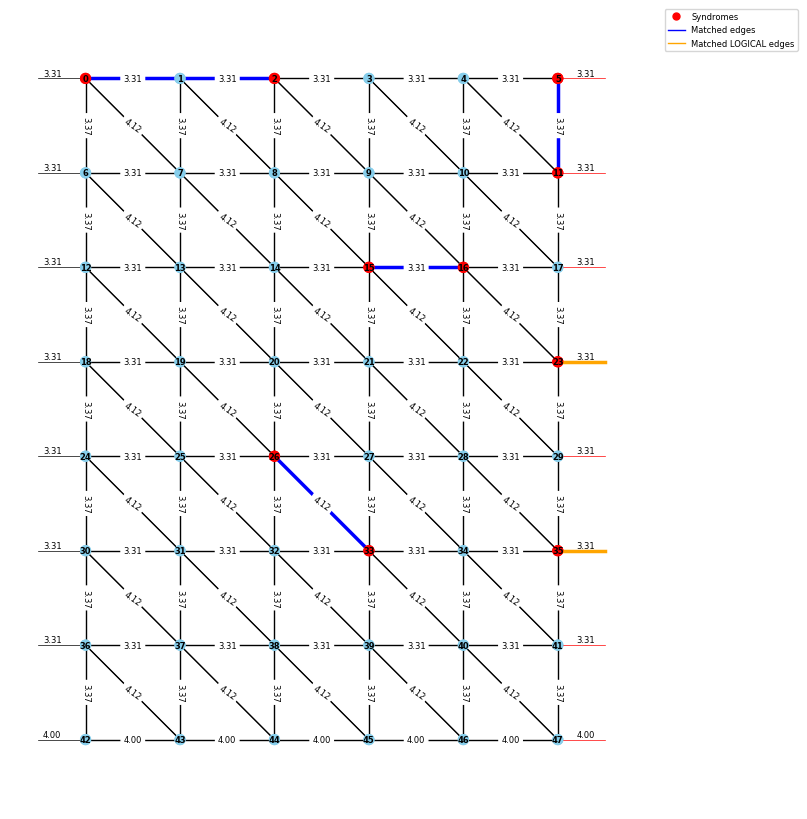

-----Second True decoding-----


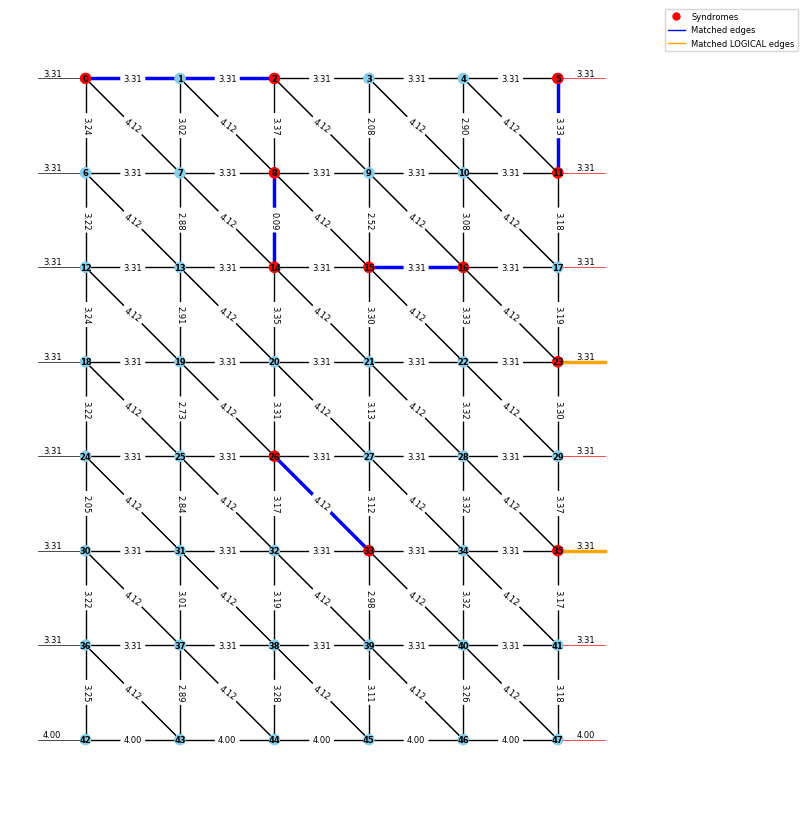

-----Second False decoding-----


IndexError: list index out of range

In [52]:
from soft_info import draw_matching_graph


index = 1637

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_predecoder.decode_result
details = to_be_result.error_details[index]
print(f"----- First {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


to_be_result = result_informed
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)
